In [1]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# Hands-on Activity 14.2: Maximum a posteriori estimate - Avoiding overfitting

## Objectives

+ To demonstrate how regularization arises naturally from a Bayesian perspective and how it can be used to avoid overfitting.

Let's load the motorcyle data to play with:

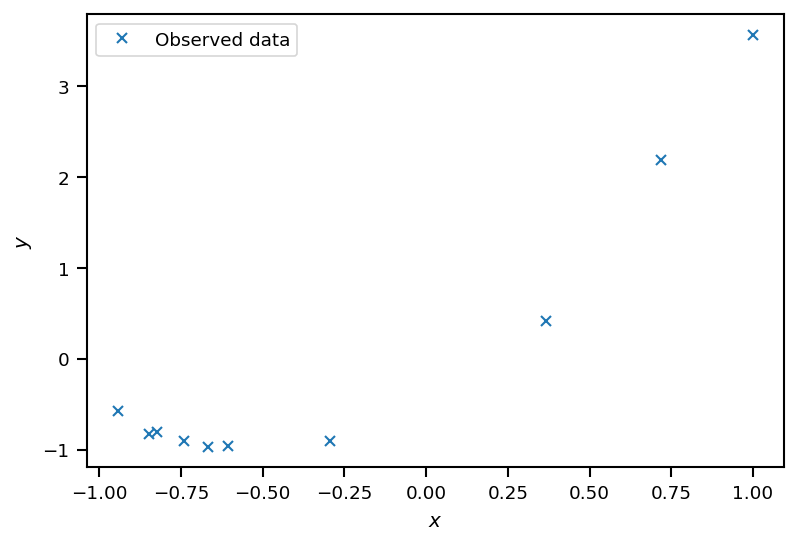

In [2]:
# How many observations we have
num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = w0_true + w1_true * x + w2_true * x ** 2 + sigma_true * np.random.randn(num_obs)
# Let's plot the data
fig, ax = plt.subplots(dpi=150)
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

Let's also copy-paste the code for creating design matrices for the three generalized linear models we have considered so far:

In [3]:
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """
    Fourier expansion with ``num_terms`` cosines and sines.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(1, int(num_terms / 2)):
        cols.append(np.cos(2 * i * np.pi / L * x))
        cols.append(np.sin(2 * i * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

As we saw in the video lecture, the problem that we need to solve to find the maximum a posteriori estimate is when the prior of the weights is a zero mean Gaussian with variance $\alpha$ is:
$$
\left(\sigma^{-2}\boldsymbol{\Phi}^T\boldsymbol{\Phi} + \alpha\mathbf{I}\right)\mathbf{w} = \sigma^{-2}\boldsymbol{\Phi}^T\mathbf{y}.
$$
This problem cannot be solved by ``numpy.linalg.lstsq``.
The stable way to solve this problem is this:

+ Construct the positive-definite matrix:
$$
\mathbf{A} = \left(\sigma^{-2}\mathbf{\Phi}^T\mathbf{\Phi}+\alpha\mathbf{I}\right)
$$
+ Compute the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\mathbf{A}$:
$$
\mathbf{A} = \mathbf{L}\mathbf{L}^T,
$$
where $\mathbf{L}$ is lower triangular.
+ Then, solve the system:
$$
\mathbf{L}\mathbf{L}^T\mathbf{w} = \sigma^{-2}\mathbf{\Phi}^T\mathbf{y}_{1:n},
$$
doing a forward and a backward substitution. The methods [scipy.linalg.cho_factor](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.cho_factor.html#scipy.linalg.cho_factor) and [scipy.linalg.cho_solve](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.linalg.cho_solve.html) can be used for this. We implement this process below:

In [4]:
# I need this to take the Cholesky decomposition
import scipy

def find_w_map(Phi, y, sigma2, alpha):
    """
    Return the MAP weights of a Bayesian linear regression problem with
    design matrix ``Phi`` observed targets ``y``, noise variance ``sigma2``
    and priors for the weights ``alpha``.
    """
    A = np.dot(Phi.T, Phi) / sigma2 + alpha * np.eye(Phi.shape[1])
    L = scipy.linalg.cho_factor(A)
    w = scipy.linalg.cho_solve(L, np.dot(Phi.T, y / sigma2))
    return w

Let's apply this to the synthetic dataset.

In [5]:
# Select polynomial degree and get design matrix
degree = 6
Phi = get_polynomial_design_matrix(x[:, None], degree)

In [6]:
# Pick variance (here I am using the true one)
sigma2 = 0.1 ** 2
# Pick the regularization parameter:
alpha = 100.0
# Solve for the MAP of the weights:
w = find_w_map(Phi, y, sigma2, alpha)

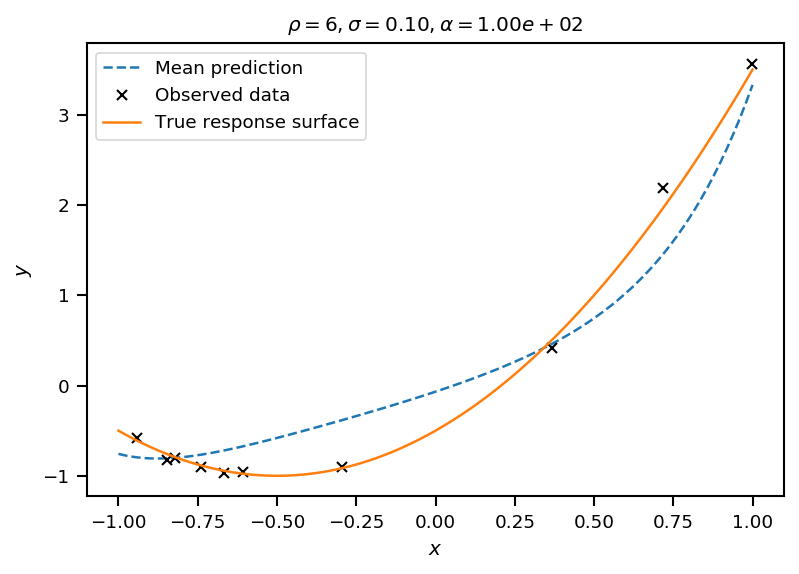

In [7]:
# Plot the results
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# The mean prediction of the model we just fitted
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy = np.dot(Phi_xx, w)
# plot mean prediction
ax.plot(xx, yy, '--', label='Mean prediction')
# plot shaded area for 95% credible interval
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'$\rho={0:d}, \sigma = {1:1.2f}, \alpha={2:1.2e}$'.format(degree, np.sqrt(sigma2), alpha))
plt.legend(loc='best');

## Questions

+ Experiment with different $\alpha$'s. Notice that for very small $\alpha$'s we are overfitting. Notice that with very large $\alpha$'s, we are underfitting.

## Selecting $\alpha$ through a validation set

Let's plot the mean square error of a validation dataset as a function of $\alpha$.

In [8]:
# The validation dataset
x_valid = -1.0 + 2 * np.random.rand(20)
y_valid = w0_true + w1_true * x_valid + w2_true * x_valid ** 2 + sigma_true * np.random.randn(x_valid.shape[0])

In [9]:
# Start increasing the number of Fourier terms and check the mean square error
# Fit the Fourier model
MSE = []
alphas = np.linspace(0.01, 20.0, 20)
for alpha in alphas:
    w = find_w_map(Phi, y, sigma2, alpha)    # Make predictions on the validation data
    Phi_valid = get_polynomial_design_matrix(x_valid[:, None], degree)
    y_valid_predict = np.dot(Phi_valid, w)
    # Calculate the mean square error
    MSE_alpha = np.linalg.norm(y_valid_predict - y_valid)
    MSE.append(MSE_alpha)

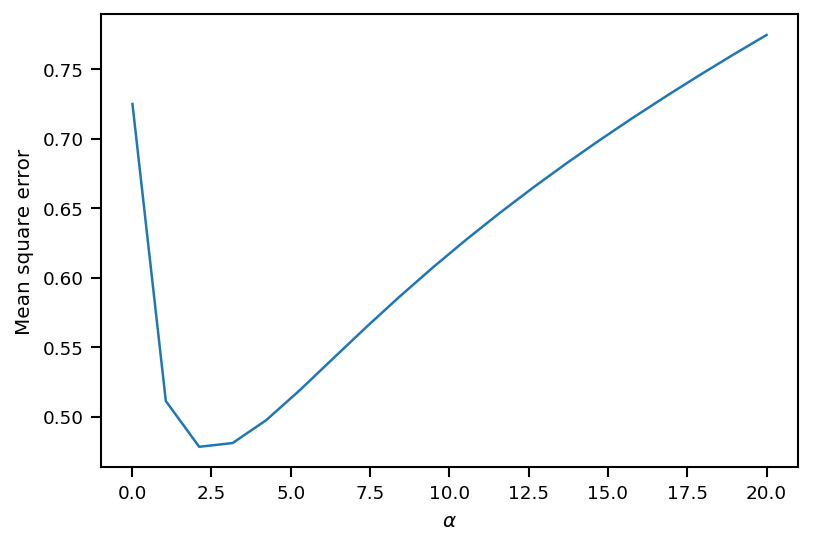

In [10]:
fig, ax = plt.subplots(dpi=150)
ax.plot(alphas, MSE)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Mean square error');

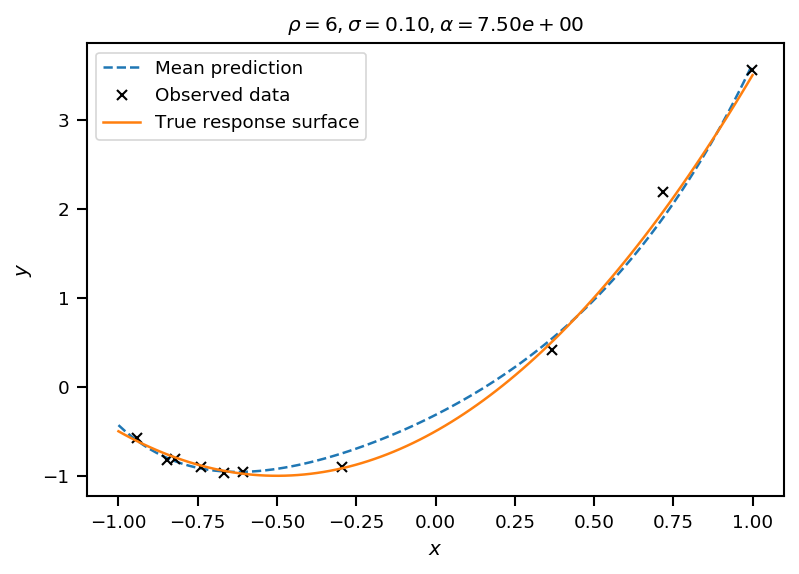

In [11]:
# Pick the regularization parameter:
alpha = 7.5
# Solve for the MAP of the weights:
w = find_w_map(Phi, y, sigma2, alpha)
# Plot the results
fig, ax = plt.subplots(dpi=150)
# Some points on which to evaluate the regression function
xx = np.linspace(-1, 1, 100)
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# The mean prediction of the model we just fitted
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy = np.dot(Phi_xx, w)
# plot mean prediction
ax.plot(xx, yy, '--', label='Mean prediction')
# plot shaded area for 95% credible interval
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# overlay the true 
ax.plot(xx, yy_true, label='True response surface')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(r'$\rho={0:d}, \sigma = {1:1.2f}, \alpha={2:1.2e}$'.format(degree, np.sqrt(sigma2), alpha))
plt.legend(loc='best');

## Questions
+ Rerun the code cell above with an $\alpha$ that is smaller than the optimal one. Observe how we overfit.
+ Rerun the code cell above with an $\alpha$ that is greater than the optimal one. Observe how we underfit.